In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [2]:
# import my modules for reading dataframes from folder /modules

import sys

sys.path.insert(0, 'modules/')
    
from tumor_data_processor_with_sex_chr import * 
from tumor_data_processor_2 import * 
from lengths_data_processor import *
from centromeres_data_processor import *

In [3]:
data = pd.read_csv('datasets/P6.Inform/I062.007.WGS.Tumor_events.txt', sep='\t', comment='#')

data

,Chromosome Region,Event,Length,Cytoband,% of CNV Overlap,Probe Median,% Heterozygous,Probes,Count of Gene Symbols
0,"chr1:0-85,008,845",Allelic Imbalance,85008846,p36.33 - p22.3,19.333367,0.072865,75.000000,4,1151
1,"chr1:85,008,845-87,491,349",CN Gain,2482505,p22.3,7.682284,0.198644,NaN,75,28
2,"chr1:113,613,048-121,177,008",CN Gain,7563961,p13.2 - p11.2,38.779621,0.244507,NaN,227,83
3,"chr1:142,535,839-145,880,697",Allelic Imbalance,3344859,q12 - q21.1,89.782915,0.223258,77.777778,18,47
4,"chr1:144,014,595-145,880,697",CN Gain,1866103,q21.1,94.069617,0.253384,66.666667,61,39
...,...,...,...,...,...,...,...,...,...
114,"chr22:16,156,754-16,356,594",CN Gain,199841,q11.1,100.000000,0.210388,NaN,12,7
115,"chr22:43,554,222-51,304,566",CN Loss,7750345,q13.2 - q13.33,38.884068,-0.282279,NaN,245,114
116,"chrX:33,264,811-34,430,371",CN Gain,1165561,p21.1,85.049847,0.218255,NaN,34,2
117,"chrX:34,696,594-35,371,655",CN Gain,675062,p21.1,40.114153,0.281110,NaN,20,1


In [4]:
test_data = process_tumor_data_with_sex(data)

test_data

,Chromosome,Copy Number,Length,Start,End
0,1,3,2482504,85008845,87491349
1,1,3,7563960,113613048,121177008
2,1,3,1866102,144014595,145880697
3,1,3,2685757,147829922,150515679
4,1,3,949190,151761217,152710407
...,...,...,...,...,...
100,22,3,199840,16156754,16356594
101,22,1,7750344,43554222,51304566
102,X,3,1165560,33264811,34430371
103,X,3,675061,34696594,35371655


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Chromosome   105 non-null    object
 1   Copy Number  105 non-null    int64 
 2   Length       105 non-null    int64 
 3   Start        105 non-null    int64 
 4   End          105 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 4.2+ KB


In [6]:
lengths = pd.read_csv('datasets/hs37d5.fa.fai', sep='\t', header=None)

In [7]:
lengths = process_lengths_data(lengths)

# data is in good format
lengths

,Length
Chromosome,
1,249250621
2,243199373
3,198022430
4,191154276
5,180915260
6,171115067
7,159138663
8,146364022
9,141213431


In [8]:
centromeres = pd.read_csv('datasets/centromeres.txt', sep='\t')

centromeres = process_centromeres_data(centromeres)

centromeres

,Chromosome,Start,End
0,1,121535434,124535434
1,2,92326171,95326171
2,3,90504854,93504854
3,4,49660117,52660117
4,5,46405641,49405641
5,6,58830166,61830166
6,7,58054331,61054331
7,8,43838887,46838887
8,9,47367679,50367679
9,X,58632012,61632012


### Initializing VCF parser

In [9]:
import vcf

vcf_reader_raw = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')
vcf_reader = vcf.Reader(filename='datasets/P6.Inform/P13.WES.Discovery.vcf.gz')

In [10]:
def check_info_attributes(keys, attributes):
    for attr in attributes:
        if attr not in keys:
            return False
        
    return True

Counting some statistics from VCF

In [11]:
vcf_reader_raw_1 = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')

count = 0
filtered = 0

for record in vcf_reader_raw_1: 
    info = record.INFO
    
#     QD>10.0, MQ>40.0, FS<30.0, SOR<3.0, MQRankSum>-12.5 and ReadPOsRankSum>-8.0
    if check_info_attributes(info.keys(), ['QD', 'MQ', 'FS', 'SOR', 'MQRankSum', 'ReadPosRankSum']) and info['QD'] > 10.0 and info['MQ'] > 40.0 and info['FS'] < 30.0 and info['SOR'] < 3.0 and info['MQRankSum'] > -12.5 and info['ReadPosRankSum'] > -8.0:
        filtered += 1

    count += 1 
    
print((filtered / count) * 100)
print(count)
print(filtered)

59.83167559296098
23526
14076


In [12]:
vcf_reader_raw_1 = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')
quals = np.array([])

for record in vcf_reader_raw_1: 
    if 'MQRankSum' not in record.INFO.keys():
        quals = np.append(quals, record.QUAL)

print(np.mean(quals))

24602.515794634593


In [13]:
vcf_reader_raw_1 = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')
allele_freqs = np.array([])

for record in vcf_reader_raw_1: 
    if 'MQRankSum' not in record.INFO.keys():
        tumor_I062_007 = record.samples[2]
        
        if tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':

            if tumor_I062_007['AD'][1] == 0:
                allele_freq = 0
            else:
                allele_freq = tumor_I062_007['AD'][1] / (tumor_I062_007['AD'][0] + tumor_I062_007['AD'][1])
                
            allele_freqs = np.append(allele_freqs, allele_freq)

print(np.median(allele_freqs))
print(np.mean(allele_freqs))

1.0
0.99954311191951


In [14]:
vcf_reader_raw_1 = vcf.Reader(filename='datasets/P6.Inform/P13.WES.raw.vcf.gz')
depths = np.array([])

for record in vcf_reader_raw_1: 
    if 'MQRankSum' not in record.INFO.keys():
        tumor_I062_007 = record.samples[2]
        
        if tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':
            depths = np.append(depths, tumor_I062_007['DP'])
                
print(np.mean(depths))

113.65233575283827


### Fill profile by segments with copy number 2

Some constants and parameters:

In [15]:
Mb = 1000000
S_small = 3 * Mb
LST_SMb = 10 * Mb
qual_threshold = 200

In [16]:
# TODO refactoring - count length in this function
def insert_row(df, _chr, cn, length, start, end, index):
    normal_segment = pd.DataFrame({
        'Chromosome': [ _chr ],
        'Copy Number': [ cn ],
        'Length': [length],
        'Start': [ start ],
        'End': [ end ]
    })
                
    return pd.concat([df.iloc[:index], normal_segment, df.iloc[index:]]).reset_index(drop=True)


def fill_segments(data):
    df = data.copy()
    index_df = 0

    for index, row in data.iterrows():

        # first cnv region in chromosome
        if index == 0 or data.loc[index-1, 'Chromosome'] != data.loc[index, 'Chromosome']:
            if row['Start'] != 0:
                df = insert_row(df, row['Chromosome'], 2, row['Start'], 0, row['Start'], index_df)
                index_df += 1

        # not first cnv region in chromosome 
        elif data.loc[index-1, 'End'] != data.loc[index, 'Start']:
            prev = data.loc[index-1]

            df = insert_row(df, row['Chromosome'], 2, row['Start'] - prev['End'], prev['End'], row['Start'], index_df)
            index_df += 1

        # last cnv region in chromosome
        if index == len(data) - 1 or data.loc[index+1, 'Chromosome'] != data.loc[index, 'Chromosome']:

            chr_len = lengths.loc[row['Chromosome'], 'Length']
            if row['End'] != chr_len:      
                df = insert_row(df, row['Chromosome'], 2, chr_len - row['End'], row['End'], chr_len, index_df+1)
                index_df += 1

        index_df += 1
        
    return df

In [17]:
pd.set_option('display.max_rows', 1000)

In [18]:
filled_data = fill_segments(test_data)

filled_data

,Chromosome,Copy Number,Length,Start,End
0,1,2,85008845,0,85008845
1,1,3,2482504,85008845,87491349
2,1,2,26121699,87491349,113613048
3,1,3,7563960,113613048,121177008
4,1,2,22837587,121177008,144014595
5,1,3,1866102,144014595,145880697
6,1,2,1949225,145880697,147829922
7,1,3,2685757,147829922,150515679
8,1,2,1245538,150515679,151761217
9,1,3,949190,151761217,152710407


In [19]:
chromosome_names_female = [str(_chr) for _chr in range(1, 23)]
chromosome_names_female.append('X')

In [20]:
# TODO refactoring - get dataframe made by segments of current chromosome and then work with it
def remove_centromeres(data):
    for _chr in chromosome_names_female:
        centromere_start = centromeres.loc[centromeres['Chromosome'] == _chr, 'Start'].iloc[0]
        centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]
        
        # drop segments that start and end in centromere  
        data = data.drop(data[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_start) & (data['End'] <= centromere_end)].index)
        
        # cut segment that overlaps centromere  
        row_df = data.loc[(data['Chromosome'] == _chr) & (data['Start'] < centromere_start) & (data['End'] > centromere_end)]
        if not row_df.empty:
            row = row_df.iloc[0]
            data.loc[row.name, 'End'] = centromere_start
            data.loc[row.name, 'Length'] = centromere_start - row['Start']        
            data = insert_row(data, _chr, row['Copy Number'], row['End'] - centromere_end, centromere_end, row['End'], row.name + 1)
        
        # cut segment that ends in centromere  
        data.loc[(data['Chromosome'] == _chr) & (data['End'] >= centromere_start) & (data['End'] <= centromere_end), 'End'] = centromere_start
        
        # cut segment that starts in centromere  
        data.loc[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_start) & (data['Start'] <= centromere_end), 'Start'] = centromere_end
    
    return data

In [21]:
data_without_centromeres = remove_centromeres(filled_data)

data_without_centromeres

,Chromosome,Copy Number,Length,Start,End
0,1,2,85008845,0,85008845
1,1,3,2482504,85008845,87491349
2,1,2,26121699,87491349,113613048
3,1,3,7563960,113613048,121177008
4,1,2,358426,121177008,121535434
5,1,2,19479161,124535434,144014595
6,1,3,1866102,144014595,145880697
7,1,2,1949225,145880697,147829922
8,1,3,2685757,147829922,150515679
9,1,2,1245538,150515679,151761217


In [22]:
def name_chr_arms(data):
    data['Arm'] = 'p'
    for _chr in chromosome_names_female:
        centromere_end = centromeres.loc[centromeres['Chromosome'] == _chr, 'End'].iloc[0]

        data.loc[(data['Chromosome'] == _chr) & (data['Start'] >= centromere_end), 'Arm'] = 'q'
        
    return data

In [23]:
data_with_named_arms = name_chr_arms(data_without_centromeres)

data_with_named_arms

,Chromosome,Copy Number,Length,Start,End,Arm
0,1,2,85008845,0,85008845,p
1,1,3,2482504,85008845,87491349,p
2,1,2,26121699,87491349,113613048,p
3,1,3,7563960,113613048,121177008,p
4,1,2,358426,121177008,121535434,p
5,1,2,19479161,124535434,144014595,q
6,1,3,1866102,144014595,145880697,q
7,1,2,1949225,145880697,147829922,q
8,1,3,2685757,147829922,150515679,q
9,1,2,1245538,150515679,151761217,q


### Counting number of variants for each segment

Quality check that filters out records their characteristics don't meet requirements. If characteristics are not present, record remains.

In [24]:
def has_quality(record):
    info = record.INFO
    return record.QUAL > qual_threshold and ('QD' not in info.keys() or info['QD'] > 10.0) and ('MQ' not in info.keys() or info['MQ'] > 40.0) \
        and ('FS' not in info.keys() or info['FS'] < 30.0 ) and ('SOR' not in info.keys() or info['SOR'] < 3.0) \
        and ('MQRankSum' not in info.keys() or info['MQRankSum'] > -12.5) and ('ReadPosRankSum' not in info.keys() or info['ReadPosRankSum'] > -8.0)

In [25]:
def count_variants(data):
    filled_variants_data = data.copy()
    filled_variants_data['Variants Count'] = 0

    for index, row in filled_variants_data.iterrows():

        count = 0
        for record in vcf_reader_raw.fetch(row['Chromosome'], row['Start'], row['End']):
            tumor_I062_007 = record.samples[2]

            if has_quality(record) and tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':
                count += 1

            length_mb = filled_variants_data.loc[index, 'Length'] / 1000000
            filled_variants_data.loc[index, 'Variants Count'] = count / length_mb

    return filled_variants_data

In [26]:
filled_variants_data = count_variants(data_with_named_arms)

filled_variants_data

,Chromosome,Copy Number,Length,Start,End,Arm,Variants Count
0,1,2,85008845,0,85008845,p,9.128462
1,1,3,2482504,85008845,87491349,p,10.070477
2,1,2,26121699,87491349,113613048,p,6.125176
3,1,3,7563960,113613048,121177008,p,5.156029
4,1,2,358426,121177008,121535434,p,0.000000
5,1,2,19479161,124535434,144014595,q,0.000000
6,1,3,1866102,144014595,145880697,q,21.970932
7,1,2,1949225,145880697,147829922,q,4.104195
8,1,3,2685757,147829922,150515679,q,1.489338
9,1,2,1245538,150515679,151761217,q,18.465916


### Some visualizations

In [27]:
def plot_chromosomes_variant_count(data):
    fig,axs = plt.subplots(nrows=24, ncols=2, figsize=(15, 40), constrained_layout=True)
    max_count = data['Variants Count'].max()

    for index, name in enumerate(chromosome_names_female):
        chr_data = data[data['Chromosome'] == name]
        chr_data = chr_data.reset_index(drop=True)

        ax = axs[index // 2, index % 2]
        ax.set_ylim([0, max_count + 10])
        ax.set_title('Variant counts - chromosome ' + name, fontdict={'fontsize': 16})
        ax.bar(chr_data.index, chr_data['Variants Count'])

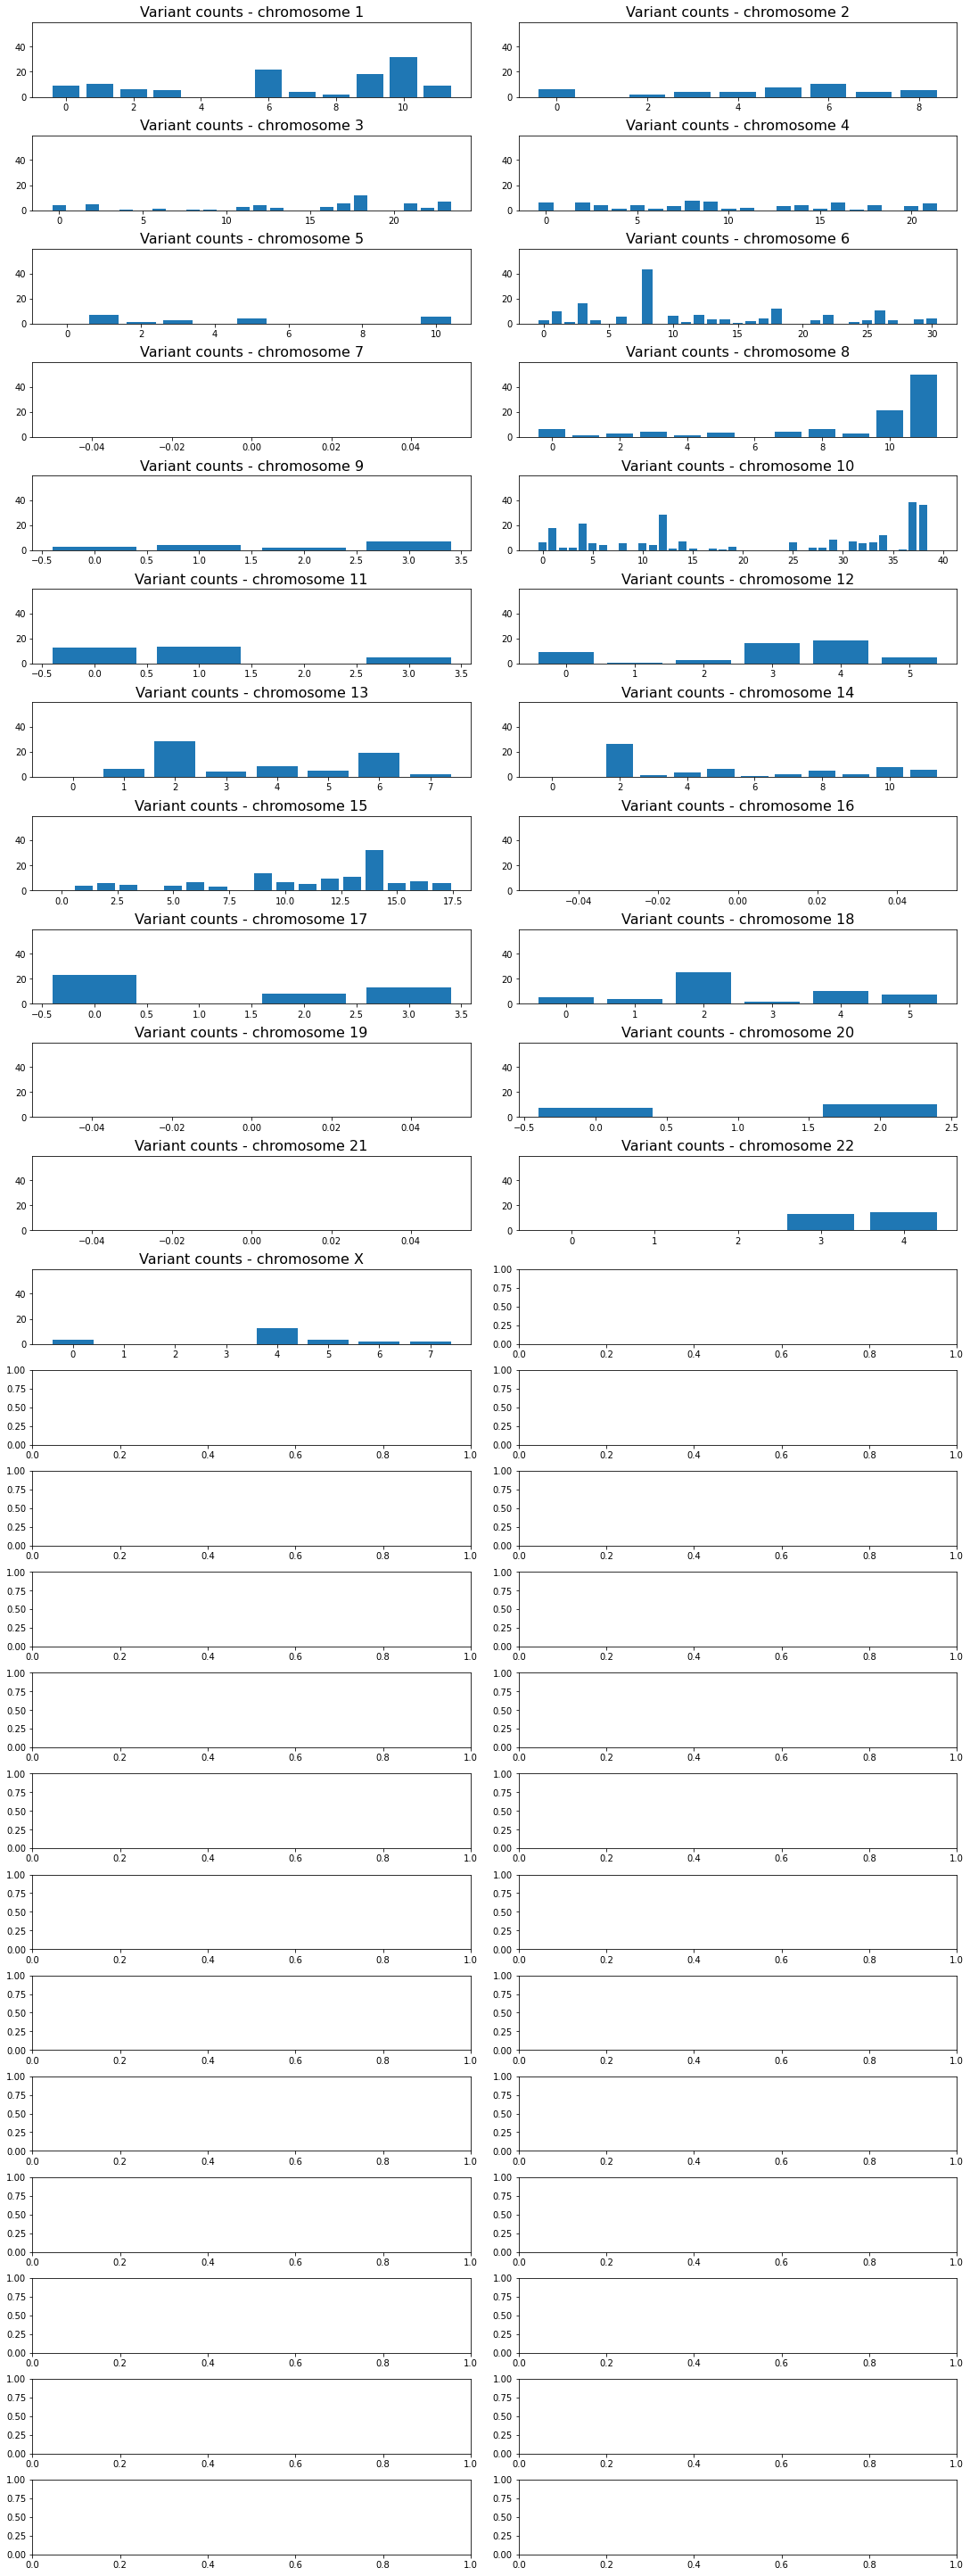

In [28]:
plot_chromosomes_variant_count(filled_variants_data)

In [29]:
def plot_genome_variant_counts(data):
    max_count = data['Variants Count'].max()
    yticks = [i for i in range(0, int(max_count) + 10, 5)]

    plt.figure(figsize=(20, 10))
    plt.yticks(ticks=yticks)
    plt.title('Variant counts', fontdict={'fontsize': 16})
    plt.bar(data.index, data['Variants Count'])

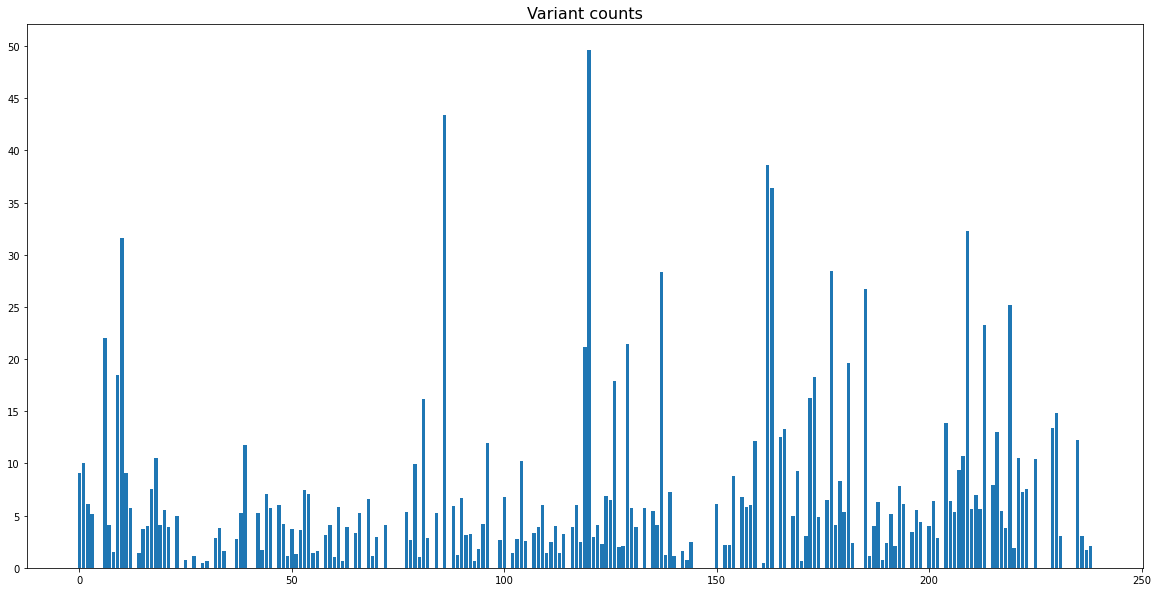

In [30]:
plot_genome_variant_counts(filled_variants_data)

### Segments sorted by number of variants

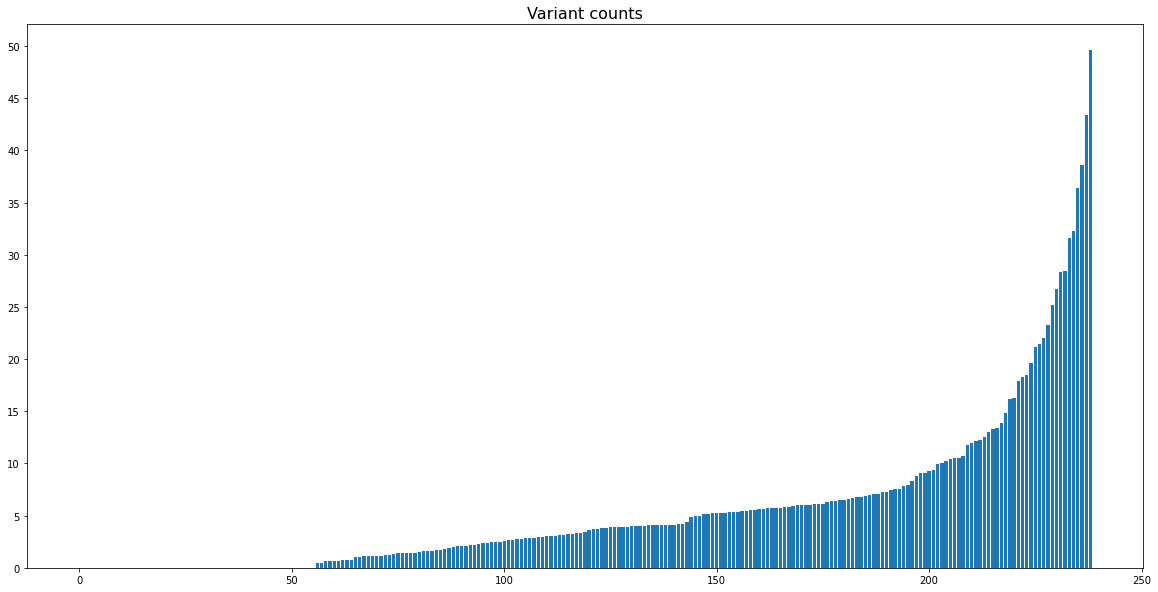

In [31]:
sorted_filled_variants_data = filled_variants_data.sort_values(by=['Variants Count']).reset_index()

plot_genome_variant_counts(sorted_filled_variants_data)

In [32]:
def plot_histogram(data):
    max_value = data['Variants Count'].max()
    xticks = [i for i in range(0, int(max_value) + 10, 2)]
    plt.figure(figsize=(20,10))
    plt.hist(data['Variants Count'], bins=int(data['Variants Count'].max()) // 2)
    plt.title('Histogram of variants count values', fontdict={'fontsize': 16})
    plt.xticks(ticks=xticks)

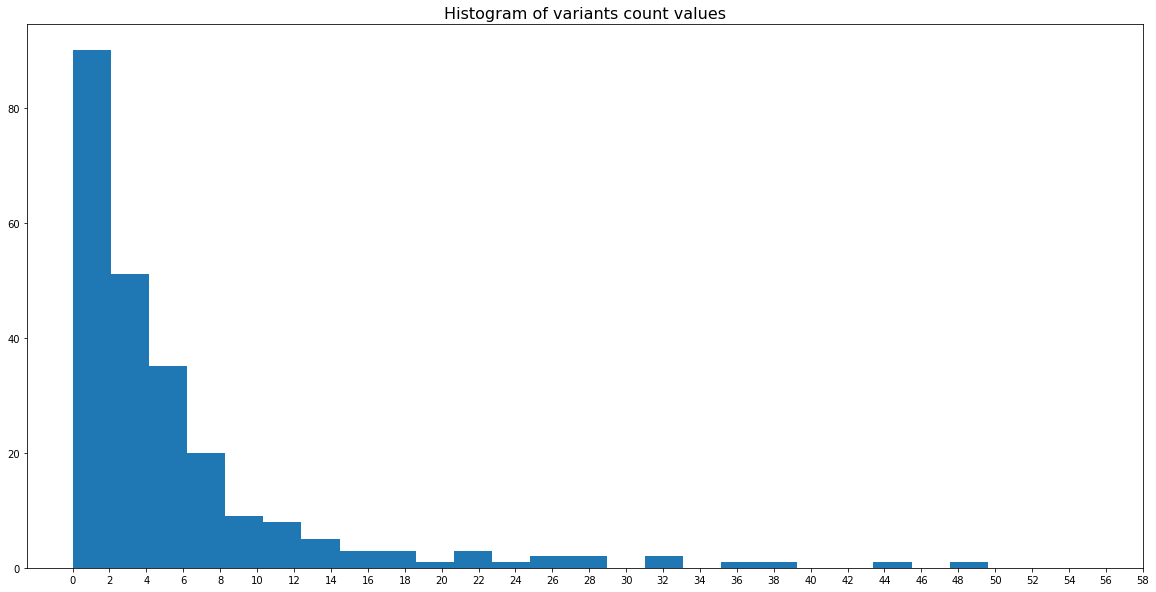

In [33]:
plot_histogram(filled_variants_data)

### Counting allelic frequencies for each segment

In [34]:
def count_allele_freqs(data):
    data_with_af = data.copy()
    data_with_af['Allelic Frequencies'] = [list() for x in range(len(data_with_af.index))]

    for index, row in data_with_af.iterrows():

        allele_freqs = []
        for record in vcf_reader_raw.fetch(row['Chromosome'], row['Start'], row['End']):
            tumor_I062_007 = record.samples[2]

            if has_quality(record) and tumor_I062_007['GT'] != './.' and tumor_I062_007['GT'] != '0/0':

                if tumor_I062_007['AD'][1] == 0:
                    allele_freq = 0
                else:
                    allele_freq = tumor_I062_007['AD'][1] / (tumor_I062_007['AD'][0] + tumor_I062_007['AD'][1])

                allele_freqs.append(allele_freq)

        data_with_af.at[index, 'Allelic Frequencies'] = allele_freqs
        
    return data_with_af

In [35]:
data_with_af = count_allele_freqs(data_with_named_arms)

data_with_af

,Chromosome,Copy Number,Length,Start,End,Arm,Allelic Frequencies
0,1,2,85008845,0,85008845,p,"[1.0, 0.5588235294117647, 1.0, 1.0, 1.0, 1.0, ..."
1,1,3,2482504,85008845,87491349,p,"[0.4854368932038835, 0.4673913043478261, 1.0, ..."
2,1,2,26121699,87491349,113613048,p,"[1.0, 0.9955156950672646, 1.0, 1.0, 0.52534562..."
3,1,3,7563960,113613048,121177008,p,"[1.0, 0.430622009569378, 1.0, 1.0, 1.0, 1.0, 0..."
4,1,2,358426,121177008,121535434,p,[]
5,1,2,19479161,124535434,144014595,q,[]
6,1,3,1866102,144014595,145880697,q,"[0.6363636363636364, 0.4755244755244755, 0.484..."
7,1,2,1949225,145880697,147829922,q,"[1.0, 1.0, 1.0, 1.0, 0.45217391304347826, 1.0,..."
8,1,3,2685757,147829922,150515679,q,"[0.5789473684210527, 0.5, 1.0, 1.0]"
9,1,2,1245538,150515679,151761217,q,"[0.4642857142857143, 1.0, 0.4634146341463415, ..."


### Coercing and counting of LSTs based on copy numbers and allelic frequencies

In [36]:
# insert new segment that was created by linking 
def insert_row_with_af(df, _chr, cn, length, start, end, allele_freqs, arm, index):
    normal_segment = pd.DataFrame({
        'Chromosome': [ _chr ],
        'Copy Number': [ cn ],
        'Length': [length],
        'Start': [ start ],
        'End': [ end ],
        'Allelic Frequencies': [allele_freqs],
        'Arm': [arm]
    })
                
    return pd.concat([df.iloc[:index], normal_segment, df.iloc[index:]]).reset_index(drop=True)


# linking adjacent segments of small filtered out segment 
def link_segments_with_af(df, prev, _next, small):
    df = df.drop(index=prev.name)
    df = df.drop(index=_next.name)
    
    new_allele_freqs = []
    new_allele_freqs.extend(prev['Allelic Frequencies'])
    new_allele_freqs.extend(_next['Allelic Frequencies'])
    new_allele_freqs.extend(small['Allelic Frequencies'])
    
    df = insert_row_with_af(df, prev['Chromosome'], prev['Copy Number'],  _next['End'] - prev['Start'],  prev['Start'], _next['End'], new_allele_freqs, \
                            prev['Arm'], prev.name)
    
    return df


# statistical tests for equality of allelic frequencies for two segments
def have_equal_allele_freqs(segment1, segment2):
    alpha = 0.05
    min_n = 3
    
    allele_freqs1 = segment1['Allelic Frequencies']
    allele_freqs2 = segment2['Allelic Frequencies']
    
    # check if there is sufficient number of observations, if no, segments are compared only by copy number
    if len(allele_freqs1) < min_n and len(allele_freqs2) < min_n:
        return True
    
    if len(allele_freqs1) < min_n or len(allele_freqs2) < min_n:
        return False
    
    statistic, p_value = stats.ttest_ind(allele_freqs1, allele_freqs2, equal_var=False)
    
    if p_value > alpha:
        return True
    
    return False


# coercing function
def coercing_with_af(data):
    df = data.copy()

    while True:

        # get smallest segment
        row = df[df['Length'] == df['Length'].min()].iloc[0]
        index = row.name

        # filter out?
        if row['Length'] < S_small:

            # not first or last segment of profile?
            if index != 0 and index != len(df) - 1:
                prev = df.loc[ index-1 ]
                _next = df.loc[ index+1 ]

                # can link?
                if prev['Chromosome'] == _next['Chromosome'] and prev['Arm'] == _next['Arm'] and prev['Copy Number'] == _next['Copy Number'] \
                    and have_equal_allele_freqs(prev, _next):
                    
                    df = link_segments_with_af(df, prev, _next, row)

            # delete small segment
            df = df.drop(index=index).reset_index(drop=True)

        # if there are no small segments left -> end
        else:
            return df

In [37]:
coerced_data_with_af = coercing_with_af(data_with_af)

coerced_data_with_af

,Chromosome,Copy Number,Length,Start,End,Arm,Allelic Frequencies
0,1,2,113613048,0,113613048,p,"[1.0, 0.5588235294117647, 1.0, 1.0, 1.0, 1.0, ..."
1,1,3,7563960,113613048,121177008,p,"[1.0, 0.430622009569378, 1.0, 1.0, 1.0, 1.0, 0..."
2,1,2,19479161,124535434,144014595,q,[]
3,1,2,98734942,150515679,249250621,q,"[0.4642857142857143, 1.0, 0.4634146341463415, ..."
4,2,1,8674709,0,8674709,p,"[0.6363636363636364, 1.0, 1.0, 1.0, 1.0, 0.643..."
5,2,3,23273329,10805837,34079166,p,"[0.5045045045045045, 0.5330578512396694, 0.513..."
6,2,2,58247005,34079166,92326171,p,"[0.47019867549668876, 1.0, 0.4206896551724138,..."
7,2,2,147873202,95326171,243199373,q,"[0.46875, 0.5465116279069767, 0.52884615384615..."
8,3,2,23676138,0,23676138,p,"[0.5466666666666666, 1.0, 0.9870967741935484, ..."
9,3,2,64644318,23933350,88577668,p,"[0.5660377358490566, 0.5161290322580645, 0.638..."


Counting number of LSTs.

In [38]:
def count_lsts(data):
    
    lsts = 0
    for index, row in data.iterrows():

        # not last segment in profile?
        if index != len(data) - 1:

            _next = data.loc[index+1]
            if row['Length'] >= LST_SMb and _next['Length'] >= LST_SMb and _next['Chromosome'] == row['Chromosome'] and _next['Start'] - row['End'] < S_small:
                lsts += 1

    return lsts

In [39]:
lsts_with_af = count_lsts(coerced_data_with_af)

lsts_with_af

14

In [40]:
def lst(data):
    pass